# Milestone 3: Web Scraping

The SEC controls and regulates all publically traded companies. Companies must file documentation with them when reporting earnings reports, creating mergers, or when directors, board memebers, or ten-percent owners of companies buy or sell stocks.

These reports are filed in both HTML and TXT formats.

In [28]:
import requests
import os
import pandas as pd
import time
from bs4 import BeautifulSoup
import re
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

The SEC stores the location of these documents into a centralized index (https://www.sec.gov/Archives/edgar/full-index/) Each document has it's own entry in the `master.idx` files. Each quarter has it's own file containing the information for each document filed within that quarter going all the way back to 1993. Each document has it's corresponding CIK number, Filer Name, Form Type, Date Filed, and File Name.

We can first download those files to build our first dataset. We can set up some checks to verify we don't download files redundantly since older documents will never change. 

I'll only be pulling 2019-2021 data since this is a lot of data to handle

In [2]:
years = range(2019,2022)
quarters = ['QTR1', 'QTR2', 'QTR3', 'QTR4']
base_path = 'C://Users//hotal//Documents//DSC540/Week 7 & 8/'
current_dirs = os.listdir(path=base_path)

for yr in years:
    if str(yr) not in current_dirs:
        os.mkdir('/'.join([base_path, str(yr)]))
    current_files = os.listdir('/'.join([base_path, str(yr)]))
    
    for qtr in quarters:
        local_filename =  f'master-index-{yr}-{qtr}.txt'
        local_file_path = '/'.join([base_path, str(yr), local_filename])
        if local_filename in current_files:
            continue
        url = f'https://www.sec.gov/Archives/edgar/full-index/{yr}/{qtr}/master.idx'
        r = requests.get(url, stream=True)
        with open(local_file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=10240):
                f.write(chunk)
        time.sleep(1)

We can merge all the dataframes together to form a unified dataframe for analysis. 

In [3]:
super_frame = pd.DataFrame(columns = ["CIK", "Filer Name", "Form Type","Date Filed","Filename"])

for i in range(2019,2021):
    for j in range(1,5):
        df = pd.read_table("{}/master-index-{}-QTR{}.txt".format(i,i,j),sep="|", skiprows=11, 
                           names = ["CIK", "Filer Name", "Form Type","Date Filed","Filename"])
        super_frame = super_frame.append(df, ignore_index=True)

In [4]:
super_frame

,CIK,Filer Name,Form Type,Date Filed,Filename
0,1000045,NICHOLAS FINANCIAL INC,10-Q,2019-02-14,edgar/data/1000045/0001193125-19-039489.txt
1,1000045,NICHOLAS FINANCIAL INC,4,2019-01-15,edgar/data/1000045/0001357521-19-000001.txt
2,1000045,NICHOLAS FINANCIAL INC,4,2019-02-19,edgar/data/1000045/0001357521-19-000002.txt
3,1000045,NICHOLAS FINANCIAL INC,4,2019-03-15,edgar/data/1000045/0001357521-19-000003.txt
4,1000045,NICHOLAS FINANCIAL INC,8-K,2019-02-01,edgar/data/1000045/0001193125-19-024617.txt
...,...,...,...,...,...
1993844,9984,BARNES GROUP INC,4,2020-11-20,edgar/data/9984/0000009984-20-000124.txt
1993845,9984,BARNES GROUP INC,4,2020-12-14,edgar/data/9984/0000009984-20-000126.txt
1993846,9984,BARNES GROUP INC,8-K,2020-10-13,edgar/data/9984/0000009984-20-000109.txt
1993847,9984,BARNES GROUP INC,8-K,2020-10-23,edgar/data/9984/0000009984-20-000112.txt


In [5]:
super_frame['Form Type'].value_counts()

4             740987
8-K           138756
424B2         119474
3              65242
SC 13G/A       62386
               ...  
STOP ORDER         1
N-6F/A             1
N-2ASR             1
15F-12B/A          1
F-N/A              1
Name: Form Type, Length: 419, dtype: int64

We can see here that Form 4 is the most common type of filing. Even when only pulling 9 quarters worth of data, we have 750k entries. 

We will take a sample since we will need to eventually iterate over every single entry

In [9]:
test = super_frame[super_frame['Form Type'] == '4'].sample(50)
test.head()

,CIK,Filer Name,Form Type,Date Filed,Filename
995707,1173431,TD AMERITRADE HOLDING CORP,4,2020-02-26,edgar/data/1173431/0001173431-20-000054.txt
67675,1300713,"Anchorage Capital Master Offshore, Ltd",4,2019-03-08,edgar/data/1300713/0000905148-19-000421.txt
1382659,1543151,"Uber Technologies, Inc",4,2020-06-18,edgar/data/1543151/0001562180-20-004598.txt
1333214,1312243,Michas Athanassios,4,2020-06-15,edgar/data/1312243/0001437749-20-013154.txt
111671,1473275,Carl Heidi H.,4,2019-01-02,edgar/data/1473275/0001654954-19-000035.txt


Using string concatenation, we can form a URL leading to where the data is being kept on the SEC website

In [10]:
urls = "https://www.sec.gov/Archives/" + test['Filename']
for ind, i in enumerate(urls):
    print(i)
    if ind > 4:
        break

https://www.sec.gov/Archives/edgar/data/1173431/0001173431-20-000054.txt
https://www.sec.gov/Archives/edgar/data/1300713/0000905148-19-000421.txt
https://www.sec.gov/Archives/edgar/data/1543151/0001562180-20-004598.txt
https://www.sec.gov/Archives/edgar/data/1312243/0001437749-20-013154.txt
https://www.sec.gov/Archives/edgar/data/1473275/0001654954-19-000035.txt
https://www.sec.gov/Archives/edgar/data/1753950/0001127602-20-030401.txt


In [11]:
total_data = []

for i in test['Filename']:
    url = "https://www.sec.gov/Archives/" + i
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Some Form 4 documents contain several entries for number of shares transacted. We can iterate over all /
    # the transacted shares to get the total number
    total_shares = 0
    for i in soup.find_all('transactionshares'):
        total_shares += float(i.text)
    
    try:
        director = soup.find('isdirector').text
    except:
        director = np.nan
    
    try:
        officer = soup.find('isofficer').text
    except:
        officer = np.nan
    
    try:
        tenpercent = soup.find('istenpercentowner').text
    except:
        tenpercent = np.nan
        
    try:
        title = soup.find('officertitle').text
    except:
        title = np.nan
        
    try:
        date = pd.to_datetime(soup.find('transactiondate').text)
    except:
        date= np.nan
    
    data = [soup.find('issuercik').text, 
        soup.find('issuername').text, 
        soup.find('issuertradingsymbol').text, 
        soup.find('rptownername').text, 
        director,
        officer,
        tenpercent,
        title,
        date,
        soup.find('transactioncode').text,
        total_shares,
        re.sub(r'[^-\d]', "", soup.find('transactionpricepershare').text),
        re.sub(r'[^-\d]', "", soup.find('sharesownedfollowingtransaction').text),
        url]
    total_data.append(data)

In [12]:
form4 = pd.DataFrame(total_data, columns=['Issuer CIK', 
                                  'Issuer Name',
                                  'Issuer Trading Symbol',
                                  'Owner Name',
                                  'Is Director',
                                  'Is Officer', 'Is Ten-Percent Owner', 
                                  'Title', 
                                  'Date of Transaction' , 
                                  'Transaction Code','Shares Transacted',
                                  'Price Per Share',
                                  'Shares Owned Following Transaction', 'URL'])
form4.head(10)

,Issuer CIK,Issuer Name,Issuer Trading Symbol,Owner Name,Is Director,Is Officer,Is Ten-Percent Owner,Title,Date of Transaction,Transaction Code,Shares Transacted,Price Per Share,Shares Owned Following Transaction,URL
0,0001173431,TD AMERITRADE HOLDING CORP,AMTD,BETTINO LORENZO A,1,0,0,,2020-02-24,A,5620.0,0,26252,https://www.sec.gov/Archives/edgar/data/117343...
1,0001580156,Houghton Mifflin Harcourt Co,HMHC,"Anchorage Capital Group, L.L.C.",NaN,NaN,true,NaN,2019-03-07,S,622320.0,775,0,https://www.sec.gov/Archives/edgar/data/130071...
2,0001543151,"Uber Technologies, Inc",UBER,Krishnamurthy Nikki,false,true,false,SVP and Chief People Officer,2020-06-16,F,365.0,3349,11147600,https://www.sec.gov/Archives/edgar/data/154315...
3,0001023844,NATIONAL HOLDINGS CORP,NHLD,Michas Athanassios,1,NaN,NaN,NaN,2020-06-11,M,33334.0,,33334,https://www.sec.gov/Archives/edgar/data/131224...
4,0001515740,PREMIER BIOMEDICAL INC,BIEI,Carl Heidi H.,true,true,NaN,CFO,2018-12-20,A,500000.0,0,1000000,https://www.sec.gov/Archives/edgar/data/147327...
5,0000203527,VARIAN MEDICAL SYSTEMS INC,VAR,Toth Christopher A.,NaN,1,NaN,SVP and Pres. Oncology Systems,2020-12-01,M,130871.0,8040,7694,https://www.sec.gov/Archives/edgar/data/175395...
6,0000727207,"Accelerate Diagnostics, Inc",AXDX,SCHULER JACK W,1,0,1,,2019-05-20,J,50000.0,1903,2024423,https://www.sec.gov/Archives/edgar/data/102141...
7,0000927066,DAVITA INC.,DVA,Arway Pamela M,1,0,0,,2020-03-20,S,625.0,7125,19239,https://www.sec.gov/Archives/edgar/data/927066...
8,0001470205,"County Bancorp, Inc.",ICBK,SCHNEIDER TIMOTHY J.,1,1,0,President,2019-08-29,P,342.0,171665,110304,https://www.sec.gov/Archives/edgar/data/147020...
9,0000040888,"AEROJET ROCKETDYNE HOLDINGS, INC.",AJRD,Lundstrom Paul,NaN,1,NaN,"VP, Chief Financial Officer",2019-11-07,F,7020.0,4335,135170,https://www.sec.gov/Archives/edgar/data/168817...


This method is pretty inefficient overall, but it does work. The data we get back is a little messy since some parts of the form are filled out incorrecly, missing, or have a different data structure.

We also have the option to scrape [OpenInsider](http://openinsider.com/) which will be a lot more efficient since we won't have to make a request for every entry like before. OpenInsider also has all the most recent transactions and has data going back 4 years.

In [13]:
ticker = "AMZN"

df = pd.DataFrame()
url = 'http://openinsider.com/screener?s={}&o=&pl=&ph=&ll=&lh=&fd=1461&fdr=&td=0&tdr=&fdlyl=&fdlyh=&daysago=&xp=1&xs=1&vl=&vh=&ocl=&och=&sic1=-1&sicl=100&sich=9999&grp=0&nfl=&nfh=&nil=&nih=&nol=&noh=&v2l=&v2h=&oc2l=&oc2h=&sortcol=0&cnt=100&page='.format(ticker)
for i in range(1,100):
    tab = pd.read_html(url+str(i))
    if tab[11].columns[1] == 1:
        break
    df = pd.concat([df,tab[11]])

df = df.reset_index()
df

,index,X,Filing Date,Trade Date,Ticker,Insider Name,Title,Trade Type,Price,Qty,Owned,ΔOwn,Value,1d,1w,1m,6m
0,0,NaN,2021-01-07 16:11:50,2021-01-05,AMZN,Rubinstein Jonathan,Dir,S - Sale,"$3,166.01",-314,6758,-4%,"-$994,127",NaN,NaN,NaN,NaN
1,1,NaN,2020-12-03 16:48:47,2020-12-01,AMZN,Wilke Jeffrey A,CEO Worldwide Consumer,S - Sale,"$3,200.59",-2000,48858,-4%,"-$6,401,175",NaN,NaN,NaN,NaN
2,2,NaN,2020-11-25 16:51:21,2020-11-23,AMZN,Wilke Jeffrey A,CEO Worldwide Consumer,S - Sale,"$3,091.15",-750,50858,-1%,"-$2,318,360",NaN,NaN,NaN,NaN
3,3,NaN,2020-11-24 17:04:23,2020-11-20,AMZN,Huttenlocher Daniel P,Dir,S - Sale,"$3,114.79",-172,950,-15%,"-$535,744",NaN,NaN,NaN,NaN
4,4,D,2020-11-17 17:29:49,2020-11-16,AMZN,Wilke Jeffrey A,CEO Worldwide Consumer,S - Sale+OE,"$3,114.36",-1200,51608,-2%,"-$3,737,229",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,96,D,2017-02-17 18:14:12,2017-02-15,AMZN,Jassy Andrew R,CEO Amazon Web Services,S - Sale+OE,$838.55,-2306,74995,-3%,"-$1,933,692",1.0,0.0,1.0,NaN
197,97,D,2017-02-17 18:13:55,2017-02-15,AMZN,Blackburn Jeffrey M,SVP,S - Sale+OE,$838.45,-4787,67560,-7%,"-$4,013,638",1.0,0.0,1.0,NaN
198,98,D,2017-02-17 18:13:38,2017-02-15,AMZN,Zapolsky David,SVP,S - Sale+OE,$838.20,-1010,3026,-25%,"-$846,582",1.0,0.0,1.0,NaN
199,99,D,2017-02-17 18:13:19,2017-02-15,AMZN,Olsavsky Brian T,"SVP, CFO",S - Sale+OE,$838.55,-1512,1063,-59%,"-$1,267,894",1.0,0.0,1.0,NaN


We should be able to iterate over all of the tickers in our data, but this will take a really long time. 

In [14]:

def string_to_int(string):
    """Converts short format string values (100M/ 10B) into integers"""
    multipliers = {'K':1000, 'M':1000000, 'B':1000000000, 'T':1000000000000}
    if pd.isnull(string):
        return np.nan
    if str(string)[-1].isdigit(): # check if no suffix
        return int(string)
    mult = multipliers[string[-1].upper()] # look up suffix to get multiplier
     # convert number to float, multiply by multiplier, then make int
    return int(float(string[:-1]) * mult)

class StockAnalyzer():
   
    def __init__(self):
        # Defining the url to query
        self.url = "https://query1.finance.yahoo.com/v7/finance/download/{}?period1={}&period2={}&interval=1{}&events=history&includeAdjustedClose=true"
        self.header = { "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 \
        (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36", 
                  "X-Requested-With": "XMLHttpRequest" }
        self.screener_url = "https://finviz.com/screener.ashx?v=111"

    def get_data(self, debug=False):
        """Returns a dataframe containing company name, ticker, industry, sector and market cap"""
        # Create a dataframe to add all the data to
        df = pd.DataFrame()
        
        # Find the number of stocks by going to the last page and indexing the last stock number
        html_page_text = requests.get('https://finviz.com/screener.ashx?v=111&r=99999', headers=self.header)
        temp = pd.DataFrame(pd.read_html(html_page_text.text, na_values="-")[14])
        new_header = temp.iloc[0]
        temp = temp[1:]
        number_of_stocks = int(temp[0].values)
        
        # Iterate over all the pages to find all the stocks
        for i in np.arange(1,number_of_stocks, 20):
            self.screener_url = "https://finviz.com/screener.ashx?v=111"
            if debug == True:
                clear_output(wait=True)
                print("{:.2f}% Complete".format((i/number_of_stocks) * 100))
            self.screener_url = self.screener_url + "&r={}".format(i)
            html_page_text = requests.get(self.screener_url, headers=self.header);
            temp = pd.DataFrame(pd.read_html(html_page_text.text, na_values="-")[14])
            new_header = temp.iloc[0] #grab the first row for the header
            temp = temp[1:] #take the data less the header row
            temp.columns = new_header #set the header row as the df header
            df = pd.concat([df,temp])
        df.index = df['No.']
        df = df.drop(['No.', 'P/E', 'Price', 'Change', 'Volume'], axis=1)
        df['Market Cap'] = df['Market Cap'].apply(string_to_int)
        clear_output(wait=True)
        print("{:.2f}% Complete".format((1 * 100)))
        return df

In [15]:
# Using the get_data method from my StocksAnalyzer class I made last Milestone to get every ticker
stocks = StockAnalyzer()

In [16]:
all_stocks = stocks.get_data(debug=True)

100.00% Complete


In [17]:
all_stocks

,Ticker,Company,Sector,Industry,Country,Market Cap
No.,,,,,,
1,A,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research,USA,3.824000e+10
2,AA,Alcoa Corporation,Basic Materials,Aluminum,USA,4.000000e+09
3,AAAU,Goldman Sachs Physical Gold ETF,Financial,Exchange Traded Fund,USA,NaN
4,AACG,ATA Creativity Global,Consumer Defensive,Education & Training Services,China,1.941400e+08
5,AACQ,Artius Acquisition Inc.,Financial,Shell Companies,USA,8.186900e+08
...,...,...,...,...,...,...
7672,ZUO,"Zuora, Inc.",Technology,Software - Infrastructure,USA,1.970000e+09
7673,ZVO,Zovio Inc,Consumer Defensive,Education & Training Services,USA,1.829600e+08
7674,ZYME,Zymeworks Inc.,Healthcare,Biotechnology,Canada,1.890000e+09


**This took about 4 hours to run for me to be warned**

In [18]:
df = pd.DataFrame()

if input("This takes forever to run\nAre you sure you want to run this?: ").upper() == "Y":
    for i in all_stocks['Ticker']:
        url = 'http://openinsider.com/screener?s={}&o=&pl=&ph=&ll=&lh=&fd=1461&fdr=&td=0&tdr=&fdlyl=&fdlyh=&daysago=&xp=1&xs=1&xa=1&xd=1&xg=1&xf=1&xm=1&xx=1&xc=1&xw=1&vl=&vh=&ocl=&och=&sic1=-1&sicl=100&sich=9999&grp=0&nfl=&nfh=&nil=&nih=&nol=&noh=&v2l=&v2h=&oc2l=&oc2h=&sortcol=0&cnt=100&page='.format(i)
        for j in range(1,100):
            tab = pd.read_html(url+str(j))
            if tab[11].columns[1] == 1:
                break
            df = pd.concat([df,tab[11]])
            clear_output(wait=True)
            print(i)
            print(len(df))
    df.to_csv("Form_4.csv")

This takes forever to run
Are you sure you want to run this?: N


In [19]:
df = pd.read_csv("Form_4.csv")
df

,Unnamed: 0,X,Filing Date,Trade Date,Ticker,Insider Name,Title,Trade Type,Price,Qty,Owned,ΔOwn,Value,1d,1w,1m,6m
0,0,NaN,2021-01-21 14:01:43,2021-01-19,A,Tang Michael,"SVP, GC,, Sec.",F - Tax,$127.35,-367,54513,-1%,"-$46,737",NaN,NaN,NaN,NaN
1,1,NaN,2021-01-21 13:54:52,2020-12-01,A,Gonsalves Rodney,"VP, Corporate Controller",F - Tax,$115.36,-18,46183,0%,"-$2,076",NaN,NaN,NaN,NaN
2,2,A,2021-01-21 13:53:16,2020-11-19,A,Thaysen Jacob,SVP,F - Tax,$108.68,-15374,99830,-13%,"-$1,670,846",NaN,NaN,NaN,NaN
3,3,A,2021-01-21 13:51:28,2020-11-19,A,Raha Samraat S.,SVP,F - Tax,$108.68,-11342,54924,-17%,"-$1,232,649",NaN,NaN,NaN,NaN
4,4,A,2021-01-21 13:49:11,2020-11-19,A,McMullen Michael R.,"CEO, Pres",F - Tax,$108.68,-82635,464017,-15%,"-$8,980,772",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760344,65,AM,2019-04-09 19:21:04,2019-04-02,ZYXI,Sandgaard Thomas,"Pres, CEO, COB, 10%",S - Sale,$4.75,-16806,15083194,0%,"-$79,829",NaN,NaN,NaN,NaN
760345,66,M,2019-04-04 18:04:45,2019-04-02,ZYXI,Sandgaard Thomas,"Pres, CEO, COB, 10%",S - Sale,$4.75,-17206,15082794,0%,"-$81,729",NaN,NaN,NaN,NaN
760346,67,M,2019-03-21 16:59:25,2019-03-19,ZYXI,Sandgaard Thomas,"Pres, CEO, COB, 10%",S - Sale,$4.40,-48008,15100000,0%,"-$211,462",NaN,NaN,NaN,NaN
760347,68,M,2019-03-18 18:02:24,2019-03-14,ZYXI,Sandgaard Thomas,"Pres, CEO, COB, 10%",S - Sale,$4.49,-51992,15148008,0%,"-$233,614",NaN,NaN,NaN,NaN


We can drop drop several columsn that contain no information

In [20]:
df = df.drop(['Unnamed: 0', 'X', '1d','1w','1m','6m'], axis = 1)

df.columns = ['FilingDate', 'Date','Ticker','InsiderName','Title','TradeType','Price','Qty','Owned','ChangeOwned','Value']
df

,FilingDate,Date,Ticker,InsiderName,Title,TradeType,Price,Qty,Owned,ChangeOwned,Value
0,2021-01-21 14:01:43,2021-01-19,A,Tang Michael,"SVP, GC,, Sec.",F - Tax,$127.35,-367,54513,-1%,"-$46,737"
1,2021-01-21 13:54:52,2020-12-01,A,Gonsalves Rodney,"VP, Corporate Controller",F - Tax,$115.36,-18,46183,0%,"-$2,076"
2,2021-01-21 13:53:16,2020-11-19,A,Thaysen Jacob,SVP,F - Tax,$108.68,-15374,99830,-13%,"-$1,670,846"
3,2021-01-21 13:51:28,2020-11-19,A,Raha Samraat S.,SVP,F - Tax,$108.68,-11342,54924,-17%,"-$1,232,649"
4,2021-01-21 13:49:11,2020-11-19,A,McMullen Michael R.,"CEO, Pres",F - Tax,$108.68,-82635,464017,-15%,"-$8,980,772"
...,...,...,...,...,...,...,...,...,...,...,...
760344,2019-04-09 19:21:04,2019-04-02,ZYXI,Sandgaard Thomas,"Pres, CEO, COB, 10%",S - Sale,$4.75,-16806,15083194,0%,"-$79,829"
760345,2019-04-04 18:04:45,2019-04-02,ZYXI,Sandgaard Thomas,"Pres, CEO, COB, 10%",S - Sale,$4.75,-17206,15082794,0%,"-$81,729"
760346,2019-03-21 16:59:25,2019-03-19,ZYXI,Sandgaard Thomas,"Pres, CEO, COB, 10%",S - Sale,$4.40,-48008,15100000,0%,"-$211,462"
760347,2019-03-18 18:02:24,2019-03-14,ZYXI,Sandgaard Thomas,"Pres, CEO, COB, 10%",S - Sale,$4.49,-51992,15148008,0%,"-$233,614"


We will also need to convert the Price and Value columns into floats to help with our calculations

In [21]:
df['Value'] = df['Value'].str.replace(',', '')
df['Value'] = df['Value'].str.replace('$', '').apply(float)

df['Qty'] = df['Qty'].str.replace('+', '')
df['Qty'] = df['Qty'].str.replace(',', '').apply(float)


df['Price'] = df['Price'].str.replace(',', '')
df['Price'] = df['Price'].str.replace('$', '').apply(float)

In [22]:
df['FilingDate'] = pd.to_datetime(df['FilingDate'])
df['Date'] = pd.to_datetime(df['Date'])

In [23]:
df = df.sort_values('FilingDate')
df

,FilingDate,Date,Ticker,InsiderName,Title,TradeType,Price,Qty,Owned,ChangeOwned,Value
509100,2017-02-03 06:03:23,2017-02-02,OPK,Frost Phillip Md Et Al,"CEO, COB, 10%",P - Purchase,8.53,6000.0,183717956,0%,51156.0
605978,2017-02-03 07:41:52,2017-02-01,SHW,Cronin Jane M.,SVP - Corporate Controller,G - Gift,0.00,-216.0,5881,-4%,-0.0
605977,2017-02-03 07:41:52,2017-02-01,SHW,Cronin Jane M.,SVP - Corporate Controller,S - Sale,304.85,-939.0,5881,-14%,-286254.0
627398,2017-02-03 08:06:08,2017-02-03,STAF,Florio Nicholas,Dir,A - Grant,0.00,1000.0,89971,+1%,0.0
155053,2017-02-03 08:43:55,2017-02-01,CPB,Alexander Mark R.,SVP,F - Tax,62.23,-3376.0,150438,-2%,-210088.0
...,...,...,...,...,...,...,...,...,...,...,...
724930,2021-02-02 16:59:44,2021-01-29,WRK,Wilson Alan D,Dir,A - Grant,41.43,3862.0,35746,+12%,160003.0
712864,2021-02-02 17:02:14,2021-01-30,WAL,Boothe Timothy W,COO,F - Tax,68.18,-361.0,52158,-1%,-24613.0
715447,2021-02-02 17:03:39,2021-01-29,WDC,Ray Michael Charles,"EVP, GC, Sec",M - OptEx,44.78,8773.0,61478,+17%,392855.0
715448,2021-02-02 17:03:39,2021-01-29,WDC,Ray Michael Charles,"EVP, GC, Sec",S - Sale+OE,59.92,-22735.0,61478,-27%,-1362170.0


In [24]:
df['TradeType'].value_counts(dropna=False)

A - Grant              206880
F - Tax                141037
M - OptEx              131150
S - Sale               102662
S - Sale+OE             75753
P - Purchase            56999
C - Converted deriv     17526
G - Gift                16315
D - Sale to issuer      10589
X - OptEx                1258
W - Inherited             180
Name: TradeType, dtype: int64

Most of our transactions are in the form of A - Grants and F - Taxes. We also have several M- OptionsExercises as well, which would also be interesting to look at. The full list of codes can be found on the [SEC Website](https://www.sec.gov/files/forms-3-4-5.pdf). We are mostly interested in P-Purchase and S-Sale right now, so we will only look at those

Let's generate some charts based on the stock price and insider trading information

In [25]:
from IPython.display import clear_output
import pandas as pd
import datetime
import numpy as np
import requests

def time_to_timestamp(time, last = False):
    """Converts a mm/dd/yyyy formatted time into a unix timestamp including dates before 1/1/1970"""
    epoch = datetime.datetime(1970, 1, 1)  # calculate the epoch timestamp 
    month, day, year = time.split("/") #  extract date info from the string
    if last == True:
        day = str(int(day) + 1)
    t = datetime.datetime(int(year), int(month), int(day)) # Convert the date info to a timestamp
    diff = t-epoch  # Subtract the difference to find how mahy years, months, and days need to be subtracted/added
    return (diff.days * 24 * 60 * 60)  # Finding the number of seconds to calculate the timestamp

def total_pct_change(series):
    """Computes the total percentage value change since the origin"""
    vals = []
    for i in np.arange(0,len(series)):
        vals.append((series[i]/series[0]) - 1)
    return vals

class StockAnalyzer():
   
    def __init__(self):
        # Defining the url to query
        self.url = "https://query1.finance.yahoo.com/v7/finance/download/{}?period1={}&period2={}&interval=1{}&events=history&includeAdjustedClose=true"
        self.header = { "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 \
        (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36", 
                  "X-Requested-With": "XMLHttpRequest" }
        self.screener_url = "https://finviz.com/screener.ashx?v=111"
        
    
    def get_price(self, 
                 ticker, 
                 start = '1/1/1900', 
                 end = datetime.date.today().strftime('%m/%d/%Y') , 
                 freq = "d"):
        """Returns the daily stock prices of a single ticker within a defined timerange. """
        start = time_to_timestamp(start) 
        # End Time
        end = time_to_timestamp(end, last = True)
        stock_price = pd.read_csv(self.url.format(ticker,
                                                  start,
                                                  end,
                                                  freq), index_col=0)
        
        stock_price['PctChange'] = stock_price['Adj Close'].pct_change()
        stock_price['CumPctChange'] = total_pct_change(stock_price['Adj Close'])
        
        stock_price['Ticker'] = ticker
        stock_price.index = pd.to_datetime(stock_price.index)
        
        cols = stock_price.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        stock_price = stock_price[cols]
        
        return stock_price
    
        
    def get_prices(self, 
                   tickers, 
                   start = '1/1/1900', 
                   end = datetime.date.today().strftime('%m/%d/%Y') , 
                   freq = "d"):
        
        """Returns the daily stock prices of multiple tickers within a defined timerange."""
        start = time_to_timestamp(start) 
        # End Time
        end = time_to_timestamp(end, last = True)
        df = pd.DataFrame()
        for i in tickers:
            stock_price = pd.read_csv(self.url.format(i,
                                                  start,
                                                  end,
                                                  freq), index_col=0 )
            
            stock_price['PctChange'] = stock_price['Adj Close'].pct_change()
            stock_price['CumPctChange'] = total_pct_change(stock_price['Adj Close'])
            stock_price['Ticker'] = i
            df = pd.concat([df, stock_price])
            
        # Reordering the column names
        cols = df.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        df.index = pd.to_datetime(df.index)
        df = df[cols]
        return df


    def get_data(self, debug=False):
        """Returns a dataframe containing company name, ticker, industry, sector and market cap"""
        df = pd.DataFrame()
        for i in np.arange(1,7621, 20):
            self.screener_url = "https://finviz.com/screener.ashx?v=111"
            if debug == True:
                clear_output(wait=True)
                print("{:.2f}% Complete".format((i/7601) * 100))
            self.screener_url = self.screener_url + "&r={}".format(i)
            html_page_text = requests.get(self.screener_url, headers=self.header);
            temp = pd.DataFrame(pd.read_html(html_page_text.text, na_values="-")[14])
            new_header = temp.iloc[0] #grab the first row for the header
            temp = temp[1:] #take the data less the header row
            temp.columns = new_header #set the header row as the df header
            df = pd.concat([df,temp])
        return df

In [48]:
def insider_trades_analyzer(ticker, start_date, df):
    stocks = StockAnalyzer()
    stock = stocks.get_price(ticker, start = start_date)
    
    df = df[df['Ticker']==ticker]
    
    plt.figure(figsize=(16,9))
    plt.plot(stock['Close'], color = "grey", label = "Stock Price")
    plt.scatter(df[(df['TradeType'] == 'P - Purchase') & (df['Ticker'] == ticker)]['Date'], 
                df[(df['TradeType'] == 'P - Purchase') & (df['Ticker'] == ticker)]['Price'], s = 50, color = "green", label = "P - Purchase")
    plt.scatter(df[(df['TradeType'] == 'S - Sale') & (df['Ticker'] == ticker)]['Date'],
                df[(df['TradeType'] == 'S - Sale') & (df['Ticker'] == ticker)]['Price'], s = 50, color = "red", label="S - Sale")
    plt.title("Insider Trades for {}".format(ticker))
    plt.legend(loc="upper left")
    plt.show()


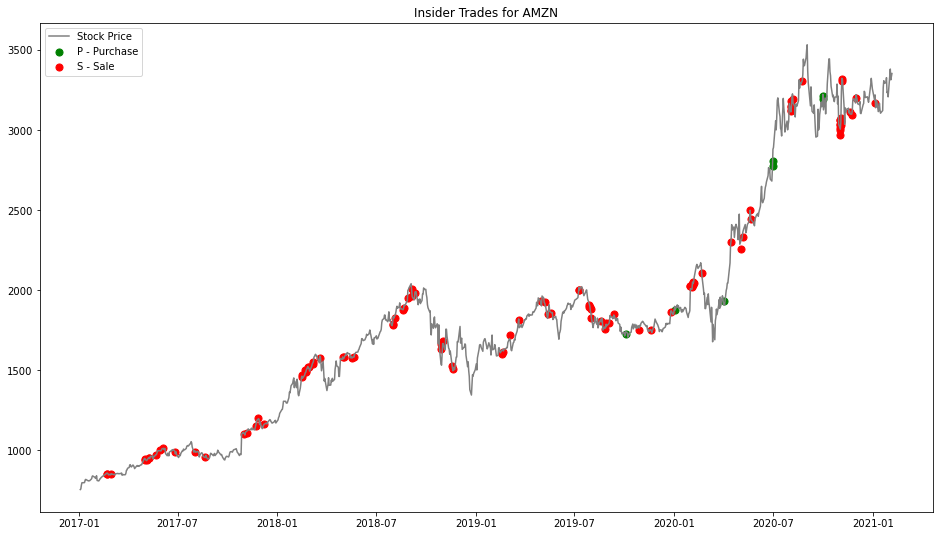

In [41]:
insider_trades_analyzer("AMZN", "01/01/2017", df)

ALX


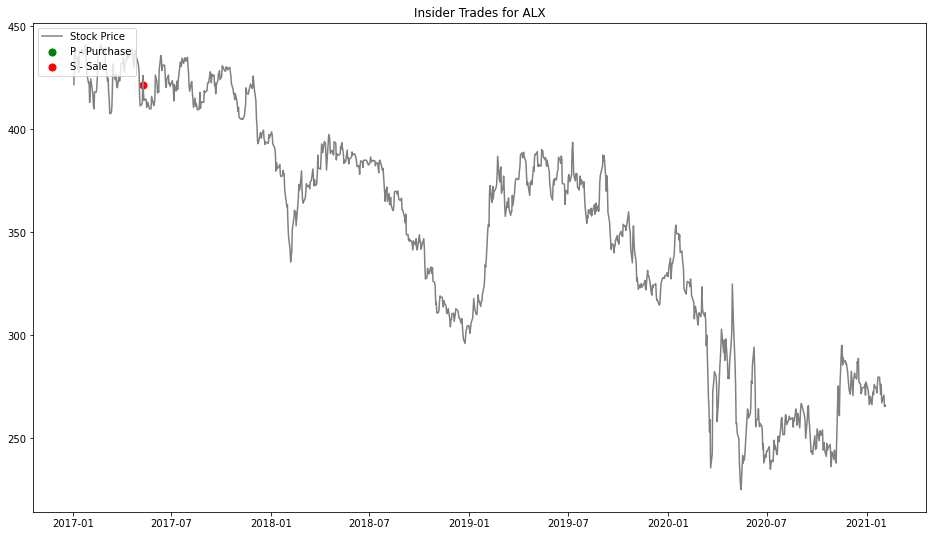

OVV


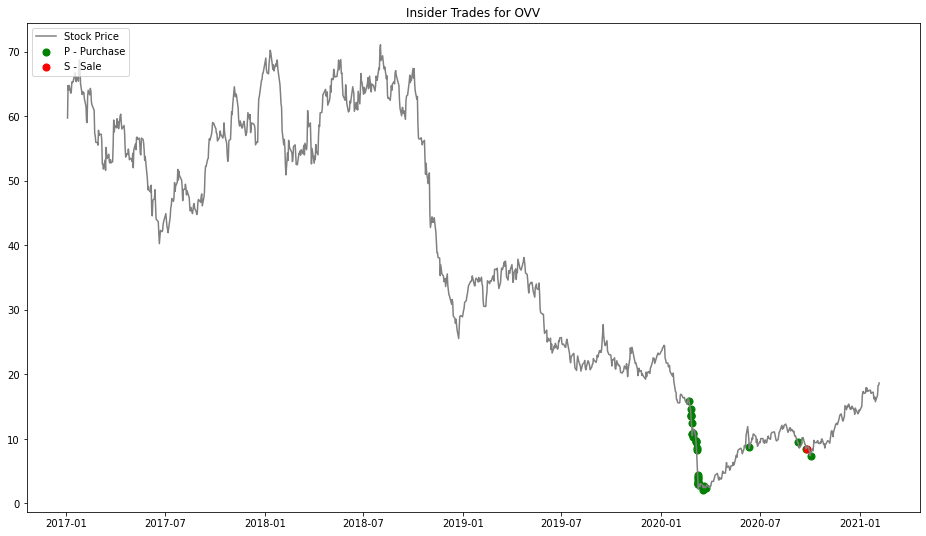

EXPR


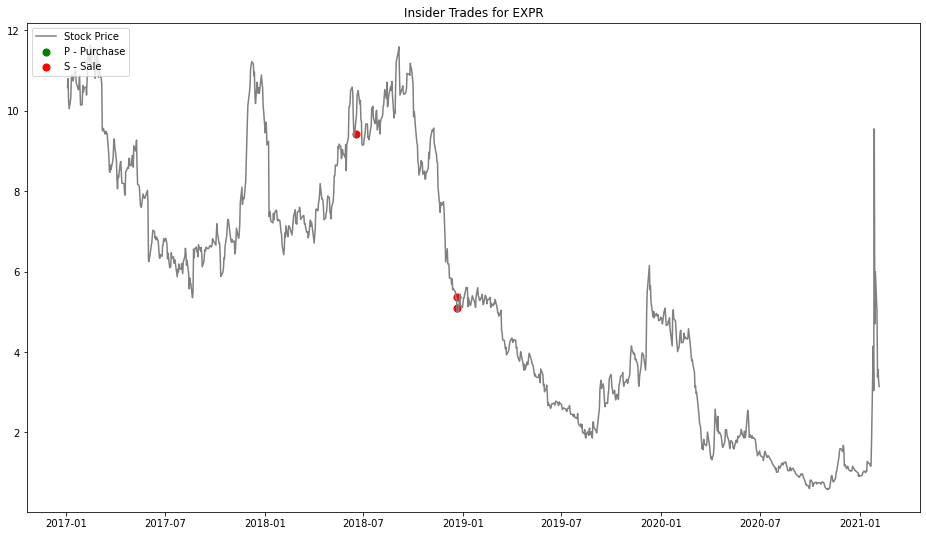

TCBI


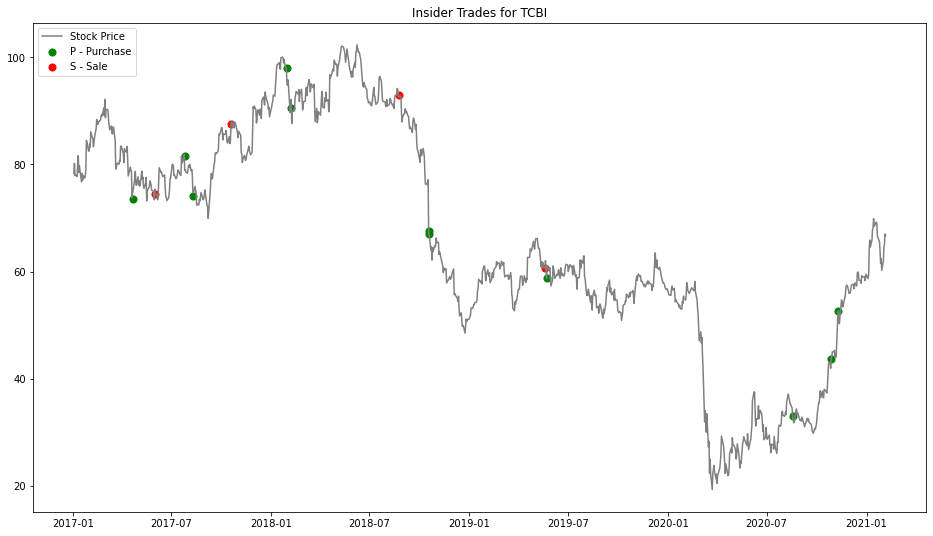

CLMT


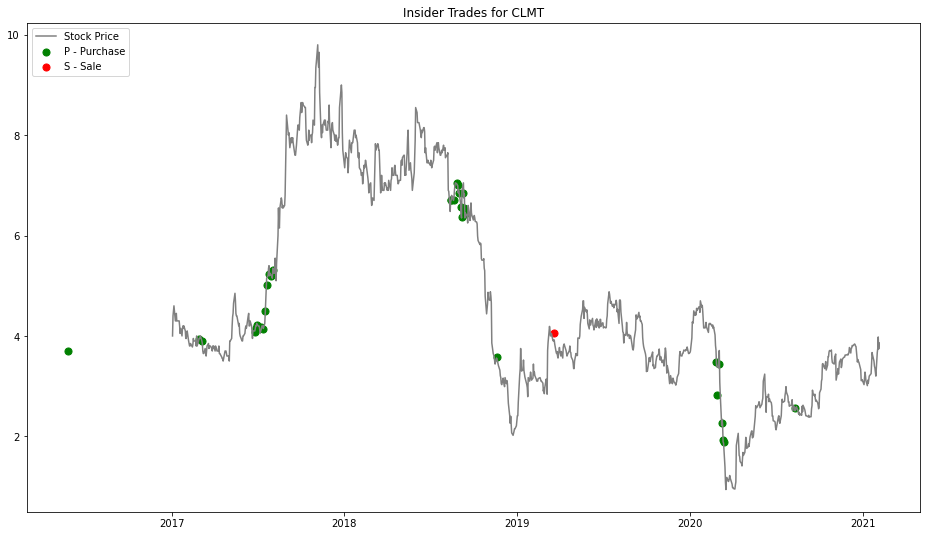

ISEE


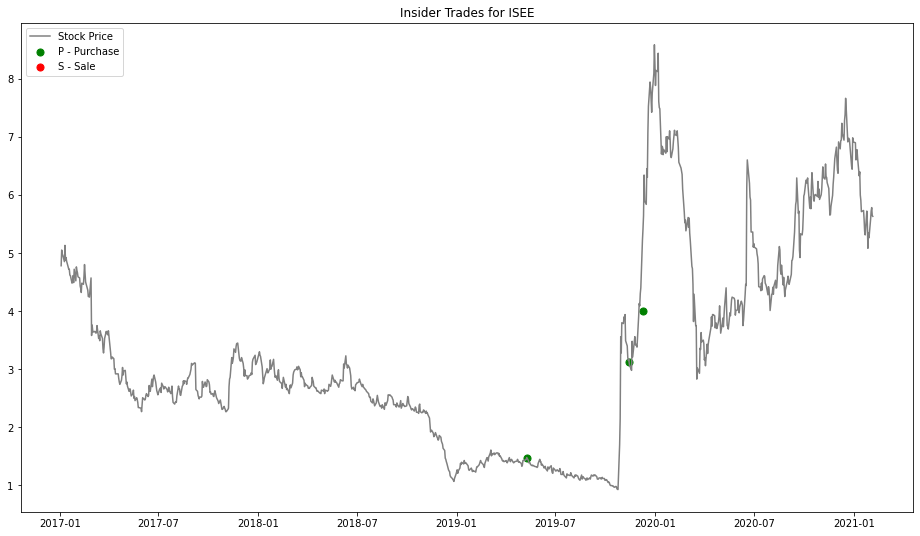

NSPR


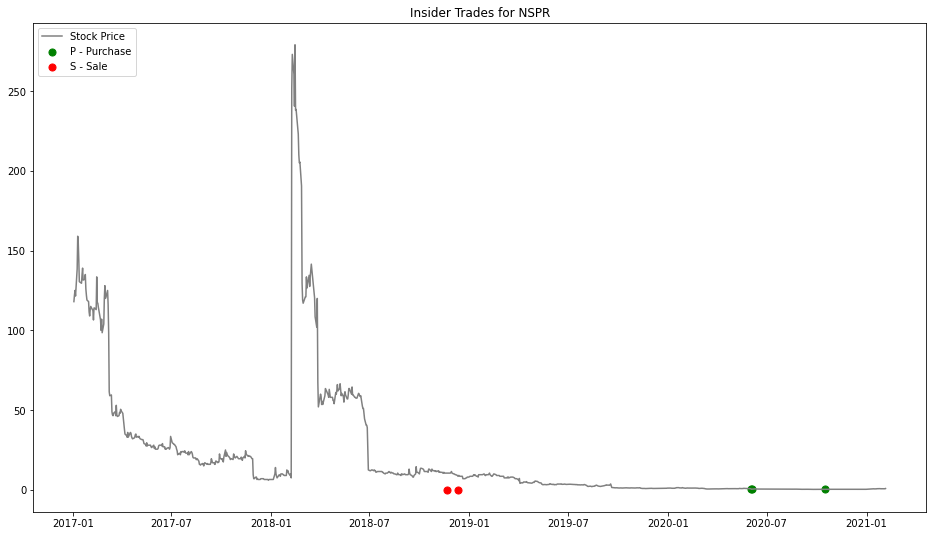

ALEC


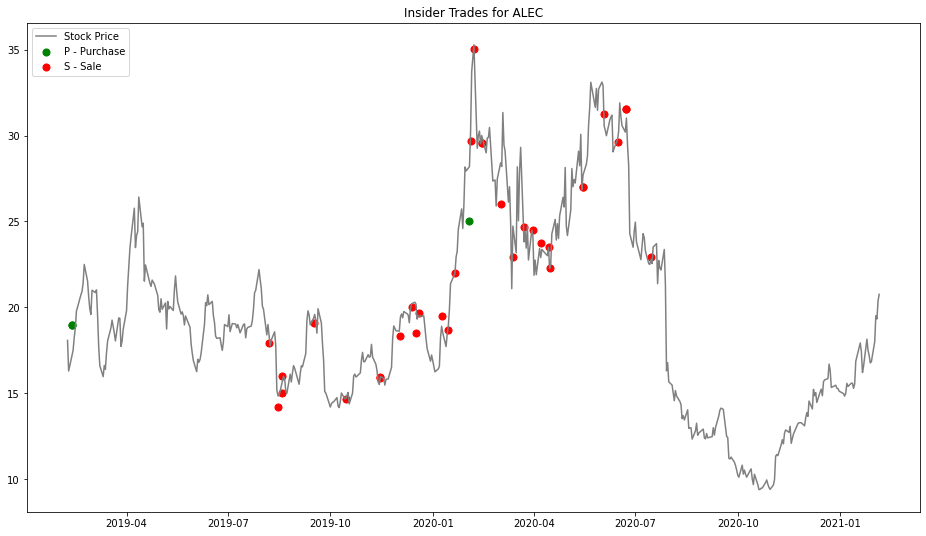

APPN


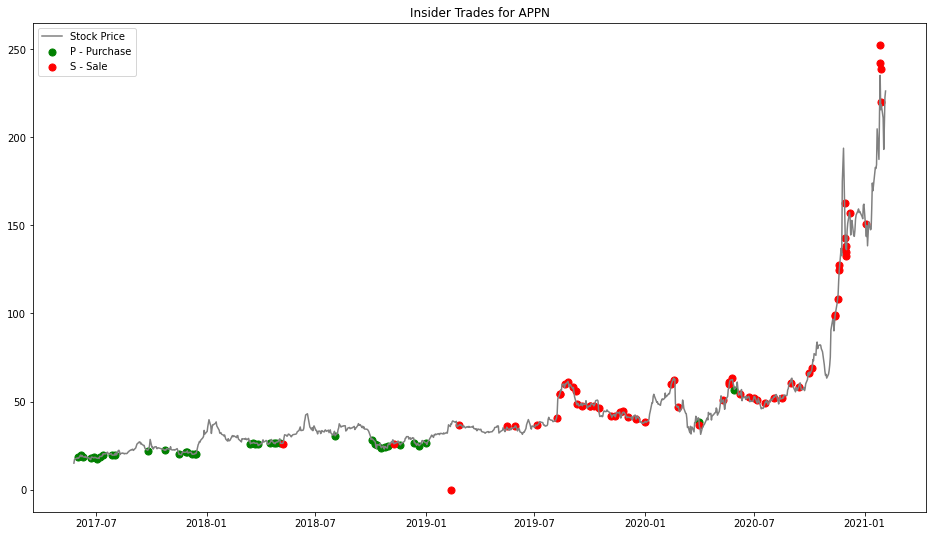

VKTX


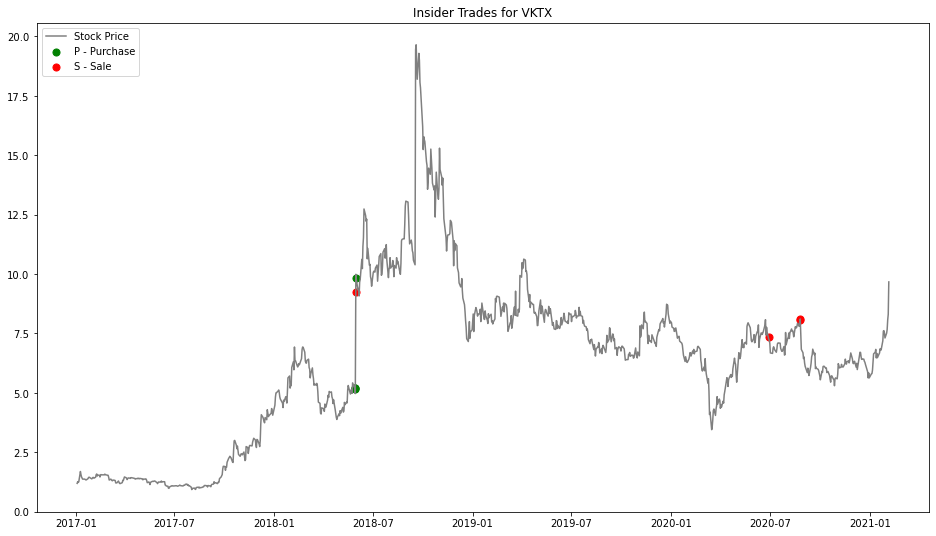

In [51]:
for i in np.random.choice(df['Ticker'].unique(), 10):
    print(i)
    try:
        insider_trades_analyzer(i, "01/01/2017", df)
    except:
        print("HTTP ERROR: Unable to find stock on Yahoo Finance")